In [1]:
import mne
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tsfresh import extract_relevant_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from numpy.fft import fft


In [2]:
raw = mne.io.read_raw_edf('C:\\Lilach\\416_for_tag_filtered.edf')
spikes = raw.annotations

Extracting EDF parameters from C:\Lilach\416_for_tag_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
spikes

<Annotations | 72 segments: END (1), Lt spike (29), Rt spike (42)>

In [4]:
spikes_df = pd.DataFrame(spikes)
end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
spikes_df = spikes_df[spikes_df['onset'] < end_onset]
spikes_df = spikes_df[spikes_df['description'].str.contains('Rt')]
# spikes_df.onset = spikes_df.onset.astype(int)
spikes_df = spikes_df.drop_duplicates(subset=['onset'])

In [5]:
len(spikes_df)

37

In [6]:
spikes_df

,onset,duration,description,orig_time
5,7.8684,0.0,Rt spike,2009-07-22 23:38:30+00:00
6,9.4970,0.0,Rt spike,2009-07-22 23:38:30+00:00
8,10.1648,0.0,Rt spike,2009-07-22 23:38:30+00:00
9,11.5555,0.0,Rt spike,2009-07-22 23:38:30+00:00
11,12.4522,0.0,Rt spike,2009-07-22 23:38:30+00:00
16,19.1292,0.0,Rt spike,2009-07-22 23:38:30+00:00
17,20.1896,0.0,Rt spike,2009-07-22 23:38:30+00:00
19,22.1932,0.0,Rt spike,2009-07-22 23:38:30+00:00
23,25.4420,0.0,Rt spike,2009-07-22 23:38:30+00:00
24,25.4613,0.0,Rt spike,2009-07-22 23:38:30+00:00


In [7]:
sr = 1000
raw_data = raw.crop(tmax=end_onset).pick_channels(['RAH1']).resample(sr).get_data()[0]

In [8]:
series_windows = []
for i in range(0, len(raw_data), sr):
    if i + sr < len(raw_data):
        series_windows.append(raw_data[i: i+sr])
#     print(i)
# raw_data[0]

In [48]:
def generate_features(x, chunk_size, sample_rate):
    x_fft = np.abs(fft(x))
    IDX_5HZ = int(np.ceil(5/(sample_rate/chunk_size)))
    IDX_25HZ = int(np.floor(25/(sample_rate/chunk_size)))
    # Bins 0-125 correspond to freq 0-30 Hz
    P_EEG1 = (x_fft[:125] ** 2).sum()
    HL_EEG1 = (x_fft[IDX_25HZ:]**2).sum() / (x_fft[:IDX_5HZ]**2).sum()
#     RMS = [np.sqrt((x_fft[2][:i]**2).mean()) for i in range(1024, len(x_fft[2])+1, 1024)]
    time_domain = [
        x.mean(),
        x.std(),
        x.max() - x.min(),
        ((x-x.mean())**3).mean(), # Skewness
        ((x - x.mean()) ** 4).mean()/(x.std()**4), # Kurtosis
        x.std()**2, # Hjorth parameter-activity
        (x**2).sum(), # Wavelet energy
        np.sqrt((x**2).mean()),
        np.sqrt(np.std(np.gradient(x))**2) # Mobility
    ]
    return np.concatenate((
        [P_EEG1, np.log(P_EEG1), HL_EEG1],
        time_domain,
        [(x_fft[:IDX_25HZ]).argmax()],
    ))

In [49]:
features_window = []
for window in series_windows:
    features_window.append(generate_features(window, len(window), sr))
    

In [59]:
pd.DataFrame(features_window)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.3683678067,-0.9986733652,0.1463527921,0.0005616538,0.0003253338,0.0012877770,-8.7290553768e-12,2.1480593063,0.0000001058,0.0004212971,0.0006490740,0.0000070966,0.0
1,0.0431381624,-3.1433472352,0.1212509204,0.0001959726,0.0000973135,0.0005359259,-4.4084785794e-13,3.6356399539,0.0000000095,0.0000478752,0.0002188040,0.0000062678,0.0
2,0.1022271100,-2.2805583718,0.8161438678,0.0001644645,0.0003877847,0.0015555746,-3.3369160757e-11,2.6624895941,0.0000001504,0.0001774256,0.0004212192,0.0000083957,1.0
3,0.0512538269,-2.9709649922,0.4942065582,0.0001683155,0.0002143585,0.0007794845,6.0752112339e-12,2.0783578263,0.0000000459,0.0000742797,0.0002725430,0.0000057003,0.0
4,0.0371933130,-3.2916262913,0.8485354434,-0.0000849986,0.0002448438,0.0010786738,-3.4182707662e-12,2.4591141243,0.0000000599,0.0000671732,0.0002591780,0.0000048599,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.0296034250,-3.5198652135,0.7365025004,0.0001003155,0.0001978361,0.0009156730,-5.0706985278e-12,3.0150550178,0.0000000391,0.0000492023,0.0002218160,0.0000045286,1.0
197,0.0229284399,-3.7753772213,0.9167398005,0.0000633750,0.0001945068,0.0007859811,2.1011129092e-12,2.4141663852,0.0000000378,0.0000418493,0.0002045710,0.0000058177,2.0
198,0.0050430621,-5.2897418290,0.5879617822,-0.0000497834,0.0000716289,0.0003088525,-2.8275049236e-13,2.8190648272,0.0000000051,0.0000076091,0.0000872301,0.0000041933,0.0
199,0.0084283105,-4.7761589453,1.1656737481,-0.0000350158,0.0001200363,0.0006817463,-1.7027342038e-12,4.8998379794,0.0000000144,0.0000156348,0.0001250393,0.0000052988,2.0


In [ ]:
y_windows = np.zeros(len(series_windows))
for onset in spikes_df['onset']:
    y_windows[int(onset) - 1] = 1

In [60]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(features_window), y_windows, stratify=y_windows)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

(150, 13) (150,) (51, 13) (51,)
[0. 1.] [125  25]


In [61]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

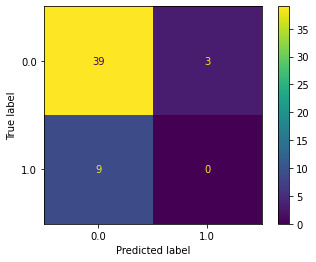

In [62]:
plot_confusion_matrix(classifier, X_test, y_test)  

In [57]:
cm = confusion_matrix(y_test, y_pred)
get_metrics(cm)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


{'accuracy': 0.7843137254901961,
 'precision': 0.0,
 'recall': 0.0,
 'f_score': nan}

***
until here i use window of 1 sec
from here it's representation of features for each data point
**************

In [9]:
features_df = pd.concat([pd.DataFrame(np.arange(sr), columns=['id']), 
           pd.DataFrame(np.arange(sr), columns=['time']), 
           pd.DataFrame(series_windows[0], columns=['amp'])], axis=1)

In [11]:
y = np.zeros(len(raw_data))
for x in spikes_df['onset']:
    if x * 1000 + 101 < len(y):
        y[int(x * 1000) - 100: int(x * 1000) + 100] = 1
y = pd.DataFrame(y)
y[0]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
100772    0.0
100773    0.0
100774    0.0
100775    0.0
100776    0.0
Name: 0, Length: 100777, dtype: float64

In [58]:
pd.options.display.precision = 10

In [27]:
raw_data

array([-2.77976772e-04, -2.93842001e-04, -3.04980805e-04, ...,
       -4.33986495e-05, -4.99337493e-05, -6.17171388e-05])

In [35]:
# from sktime.transformers.series_as_features.summarize import TSFreshFeatureExtractor

# transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
# extracted_features = transformer.fit_transform(X_train)
# extracted_features.head()
X = pd.concat([pd.DataFrame(np.arange(len(raw_data)), columns=['id']),
               pd.DataFrame(np.arange(len(raw_data)), columns=['time']),
               pd.DataFrame(raw_data, columns=['amp'])], axis=1)
X

,id,time,amp
0,0,0,-0.0002779768
1,1,1,-0.0002938420
2,2,2,-0.0003049808
3,3,3,-0.0003128303
4,4,4,-0.0003199486
...,...,...,...
100772,100772,100772,-0.0000397937
100773,100773,100773,-0.0000357934
100774,100774,100774,-0.0000433986
100775,100775,100775,-0.0000499337


In [36]:


extracted_features = extract_relevant_features(X, y[0], column_id="id", column_sort="time")
extracted_features

Feature Extraction: 100%|██████████| 20/20 [14:13<00:00, 42.70s/it]


,amp__sum_values,"amp__fft_coefficient__attr_""real""__coeff_0","amp__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","amp__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","amp__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","amp__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",amp__quantile__q_0.9,amp__quantile__q_0.8,amp__quantile__q_0.7,amp__quantile__q_0.4,...,amp__quantile__q_0.2,amp__quantile__q_0.1,amp__minimum,amp__maximum,amp__mean,amp__median,amp__quantile__q_0.3,amp__root_mean_square,amp__abs_energy,"amp__fft_coefficient__attr_""abs""__coeff_0"
0,-0.0002779768,-0.0002779768,-0.0000539108,-0.0000762413,-0.0001078215,-0.0001704808,-0.0002779768,-0.0002779768,-0.0002779768,-0.0002779768,...,-0.0002779768,-0.0002779768,-0.0002779768,-0.0002779768,-0.0002779768,-0.0002779768,-0.0002779768,0.0002779768,0.0000000773,0.0002779768
1,-0.0002938420,-0.0002938420,-0.0000569877,-0.0000805927,-0.0001139753,-0.0001802108,-0.0002938420,-0.0002938420,-0.0002938420,-0.0002938420,...,-0.0002938420,-0.0002938420,-0.0002938420,-0.0002938420,-0.0002938420,-0.0002938420,-0.0002938420,0.0002938420,0.0000000863,0.0002938420
2,-0.0003049808,-0.0003049808,-0.0000591479,-0.0000836478,-0.0001182958,-0.0001870421,-0.0003049808,-0.0003049808,-0.0003049808,-0.0003049808,...,-0.0003049808,-0.0003049808,-0.0003049808,-0.0003049808,-0.0003049808,-0.0003049808,-0.0003049808,0.0003049808,0.0000000930,0.0003049808
3,-0.0003128303,-0.0003128303,-0.0000606702,-0.0000858007,-0.0001213405,-0.0001918561,-0.0003128303,-0.0003128303,-0.0003128303,-0.0003128303,...,-0.0003128303,-0.0003128303,-0.0003128303,-0.0003128303,-0.0003128303,-0.0003128303,-0.0003128303,0.0003128303,0.0000000979,0.0003128303
4,-0.0003199486,-0.0003199486,-0.0000620508,-0.0000877530,-0.0001241015,-0.0001962217,-0.0003199486,-0.0003199486,-0.0003199486,-0.0003199486,...,-0.0003199486,-0.0003199486,-0.0003199486,-0.0003199486,-0.0003199486,-0.0003199486,-0.0003199486,0.0003199486,0.0000001024,0.0003199486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100772,-0.0000397937,-0.0000397937,-0.0000077176,-0.0000109143,-0.0000154352,-0.0000244051,-0.0000397937,-0.0000397937,-0.0000397937,-0.0000397937,...,-0.0000397937,-0.0000397937,-0.0000397937,-0.0000397937,-0.0000397937,-0.0000397937,-0.0000397937,0.0000397937,0.0000000016,0.0000397937
100773,-0.0000357934,-0.0000357934,-0.0000069418,-0.0000098171,-0.0000138835,-0.0000219518,-0.0000357934,-0.0000357934,-0.0000357934,-0.0000357934,...,-0.0000357934,-0.0000357934,-0.0000357934,-0.0000357934,-0.0000357934,-0.0000357934,-0.0000357934,0.0000357934,0.0000000013,0.0000357934
100774,-0.0000433986,-0.0000433986,-0.0000084167,-0.0000119030,-0.0000168334,-0.0000266160,-0.0000433986,-0.0000433986,-0.0000433986,-0.0000433986,...,-0.0000433986,-0.0000433986,-0.0000433986,-0.0000433986,-0.0000433986,-0.0000433986,-0.0000433986,0.0000433986,0.0000000019,0.0000433986
100775,-0.0000499337,-0.0000499337,-0.0000096841,-0.0000136954,-0.0000193683,-0.0000306239,-0.0000499337,-0.0000499337,-0.0000499337,-0.0000499337,...,-0.0000499337,-0.0000499337,-0.0000499337,-0.0000499337,-0.0000499337,-0.0000499337,-0.0000499337,0.0000499337,0.0000000025,0.0000499337


In [37]:
X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

(75582, 21) (75582, 1) (25195, 21) (25195, 1)
[0. 1.] [72695  2887]


In [38]:
# now we can apply any scikit-learn classifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


/Users/rotemfalach/projects/mne-python/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[24201,    32],
       [  958,     4]])

In [56]:
def get_metrics(cm):
    if len(cm) == 0:
        cm = np.zeros((2,2), dtype=int)
    if np.squeeze(cm).ndim < 2:
        new_cm = np.zeros((2,2), dtype=int)
        new_cm[1, 1] = int(cm[0][0])
        cm = new_cm
    numerator = cm[0, 0] + cm[1, 1]
    denominator = cm[0, 0] + cm[1, 1] + cm[0, 1] + cm[1, 0]
    accuracy = numerator / denominator
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    numerator = precision * recall
    denominator = (0.25 * precision) + recall
    f_score = 1.25 * numerator / denominator
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f_score': f_score}

In [41]:
get_metrics(cm)

{'accuracy': 0.960706489382814,
 'precision': 0.1111111111111111,
 'recall': 0.004158004158004158,
 'f_score': 0.018083182640144666}

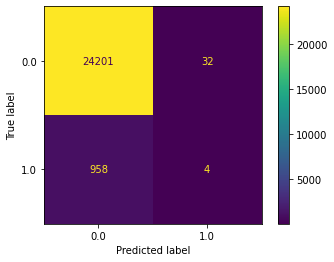

In [42]:
plot_confusion_matrix(classifier, X_test, y_test)  